# Laplace Transform — Three Views (v2.1, Dark Styled + 3D)

**What’s new in v2.1**
- **View 2** (Weighting & Accumulation) now uses a *safe fill update* pattern (no lingering collections).
- **3D view** avoids private attributes like `._axinfo` so it works across Matplotlib versions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from IPython.display import HTML, display
from scipy import integrate

# --- Dark theme styling ---
plt.rcParams.update({
    'figure.facecolor': '#0b0b0b',
    'axes.facecolor': '#0b0b0b',
    'savefig.facecolor': '#0b0b0b',
    'axes.edgecolor': '#2ad3ff',
    'axes.labelcolor': '#e6e6e6',
    'text.color': '#e6e6e6',
    'xtick.color': '#9adfff',
    'ytick.color': '#9adfff',
    'grid.color': '#1a99b3',
    'grid.linestyle': '--',
    'grid.alpha': 0.35,
    'axes.grid': True,
    'figure.dpi': 120,
    'font.size': 12,
    'axes.titleweight': 'bold'
})

ACCENT_MAGENTA = '#ff6ba6'
ACCENT_YELLOW  = '#ffd24d'
ACCENT_TEAL    = '#52e6c1'
ACCENT_WHITE   = '#f4f4f4'

def show_anim(anim, fps=15, save_mp4_path=None):
    """Try HTML5 video; fallback to JSHTML. Optionally save MP4 (needs ffmpeg)."""
    try:
        html5 = anim.to_html5_video()
        if save_mp4_path:
            try:
                writer = animation.FFMpegWriter(fps=fps)
                anim.save(save_mp4_path, writer=writer)
                print(f"Saved MP4 to: {save_mp4_path}")
            except Exception as e:
                print("MP4 save skipped:", e)
        return HTML(html5)
    except Exception as e:
        print("HTML5 video fallback (no ffmpeg):", e)
        return HTML(anim.to_jshtml())


## View 1 — Decay $e^{-\sigma t}$

Quick visual for damping as σ increases.


In [2]:
fs = 200
Tmax = 5.0
t = np.linspace(0, Tmax, int(fs*Tmax), endpoint=False)
sigmas = np.linspace(0.0, 2.0, 40)

fig, ax = plt.subplots(figsize=(7, 3.4))
(line,) = ax.plot([], [], lw=2.5, color=ACCENT_MAGENTA)
ax.set_xlim(0, Tmax); ax.set_ylim(0, 1.05)
ax.set_xlabel('t'); ax.set_ylabel('e^{-σ t}'); ax.set_title('Decay of e^{-σ t} as σ increases')
legend_txt = ax.text(0.98, 0.92, '', ha='right', va='center', transform=ax.transAxes, color=ACCENT_YELLOW)

def init():
    line.set_data([], []); legend_txt.set_text('')
    return (line, legend_txt)

def animate(i):
    sigma = sigmas[i]; y = np.exp(-sigma * t)
    line.set_data(t, y); legend_txt.set_text(f'σ = {sigma:.2f}')
    return (line, legend_txt)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sigmas), interval=80, blit=True)
display(show_anim(anim, fps=12, save_mp4_path='v2p1_view1_decay.mp4')); plt.close(fig)


Saved MP4 to: v2p1_view1_decay.mp4


## View 2 — Weighting & Accumulation (Patched)

- Shows \( f(t)e^{-\sigma t} \) with shaded area from 0 to \(T\), moving cursor, and the running integral \(I(T)\).
- Uses a *single* PolyCollection that we remove and recreate each frame (safe across Matplotlib versions).


In [3]:
fs = 200
Tmax = 6.0
t = np.linspace(0, Tmax, int(fs*Tmax), endpoint=False)

sigma = 0.6
f = np.sin(2*np.pi*1.0*t)
kernel = np.exp(-sigma * t)
integrand = f * kernel
cum_int = integrate.cumulative_trapezoid(integrand, t, initial=0.0)

fig, ax = plt.subplots(figsize=(7.6, 4.2))
ax.set_xlim(0, Tmax)
ax.set_ylim(min(integrand.min()-0.2, -1.2), max(integrand.max()+0.2, 1.2))
ax.set_xlabel('t'); ax.set_ylabel('amplitude')
ax.set_title('Weighting f(t) by e^{-σ t} and accumulating the integral')

ax.plot(t, f, lw=1.2, color=ACCENT_YELLOW, label='f(t)')
ax.plot(t, kernel, lw=1.2, color=ACCENT_TEAL, label='e^{-σ t}')
(line_fk,) = ax.plot(t, integrand, lw=1.6, color=ACCENT_MAGENTA, label='f(t)e^{-σ t}')
cursor = ax.axvline(0, color=ACCENT_WHITE, lw=1.5, linestyle=':')
ax.legend(loc='upper right')

ax2 = ax.twinx()
(line_cum,) = ax2.plot([], [], lw=2.0, color=ACCENT_WHITE)
ax2.set_ylabel('I(T) = ∫_0^T f(τ)e^{-σ τ} dτ')

txt_T = ax.text(0.02, 0.92, '', transform=ax.transAxes, color=ACCENT_WHITE)
txt_I = ax2.text(0.98, 0.08, '', transform=ax2.transAxes, ha='right', color=ACCENT_WHITE)

frames = 180
indices = np.linspace(2, len(t), frames, dtype=int)

# Holder for the fill PolyCollection
fill_coll = [None]

def init():
    line_cum.set_data([], [])
    return (line_fk, line_cum, cursor)

def animate(i):
    idx = indices[i]
    ti = t[:idx]
    yi = integrand[:idx]
    Ii = cum_int[:idx]

    # Remove previous fill if it exists
    if fill_coll[0] is not None:
        try:
            fill_coll[0].remove()
        except Exception:
            pass

    # Create new fill up to current T
    fill_coll[0] = ax.fill_between(ti, yi, 0, color=ACCENT_MAGENTA, alpha=0.18)

    # Update cursor and cumulative plot
    cursor.set_xdata(t[idx-1])
    line_cum.set_data(ti, Ii)

    txt_T.set_text(f'T = {t[idx-1]:.2f} s,  σ = {sigma:.2f}')
    txt_I.set_text(f'I(T) = {Ii[-1]:.4f}')
    return (line_fk, line_cum, cursor)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(indices), interval=60, blit=False)
display(show_anim(anim, fps=15, save_mp4_path='v2p1_view2_weighting.mp4')); plt.close(fig)


C:\Users\felip\AppData\Local\Temp\ipykernel_8492\3179421732.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(t[idx-1])
C:\Users\felip\AppData\Local\Temp\ipykernel_8492\3179421732.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cursor.set_xdata(t[idx-1])


Saved MP4 to: v2p1_view2_weighting.mp4


## View 3 — s-plane Sweep for \(F(s)=1/(s+1)\)


In [4]:
omegas = np.linspace(0, 12*np.pi, 600)
sigmas = np.linspace(-0.5, 2.0, 45)

fig, ax = plt.subplots(figsize=(7.2, 4.0))
ax.set_xlim(0, np.max(omegas)); ax.set_ylim(0, 1.2)
ax.set_xlabel('ω'); ax.set_ylabel('|F(σ + jω)|')
ax.set_title('Sweep along σ+jω for F(s)=1/(s+1); ROC: Re(s) > -1')
(line,) = ax.plot([], [], lw=2.0, color=ACCENT_TEAL)
txt = ax.text(0.02, 0.90, '', transform=ax.transAxes, color=ACCENT_YELLOW)

def init():
    line.set_data([], []); txt.set_text('')
    return (line, txt)

def animate(i):
    sigma = sigmas[i]
    Fmag = 1.0/np.sqrt((sigma+1.0)**2 + omegas**2)
    line.set_data(omegas, Fmag); txt.set_text(f'σ = {sigma:.2f}  (ROC: Re(s) > -1)')
    return (line, txt)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sigmas), interval=80, blit=True)
display(show_anim(anim, fps=12, save_mp4_path='v2p1_view3_splane.mp4')); plt.close(fig)


Saved MP4 to: v2p1_view3_splane.mp4


## View 4 — 3D Surface of \(|1/s|\) (Compatible Styling)

Avoids private attributes; uses dark background, plasma surface, and a simple rotating camera.


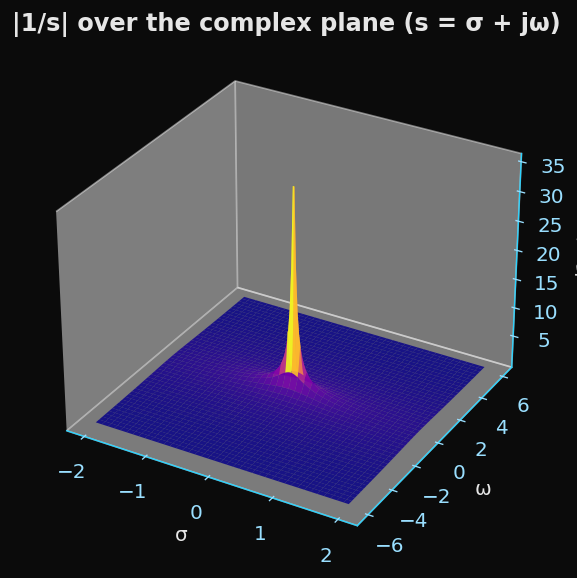

Saved MP4 to: v2p1_view4_surface3d.mp4


In [5]:
# Domain in σ and ω
sigma_min, sigma_max = -2.0, 2.0
omega_min, omega_max = -6.0, 6.0
n_sigma, n_omega = 160, 240

sigma = np.linspace(sigma_min, sigma_max, n_sigma)
omega = np.linspace(omega_min, omega_max, n_omega)
S, W = np.meshgrid(sigma, omega, indexing='xy')

# Height: |1/s| = 1/sqrt(sigma^2 + omega^2); avoid division by zero at (0,0)
R = np.sqrt(S**2 + W**2)
Z = 1.0 / np.maximum(R, 1e-6)

# Static 3D surface (no private attribute usage)
fig = plt.figure(figsize=(7.5, 5.6))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('#0b0b0b')
surf = ax.plot_surface(S, W, Z, cmap='plasma', linewidth=0, antialiased=True, alpha=0.9)
ax.set_xlabel('σ'); ax.set_ylabel('ω'); ax.set_zlabel('|1/s|')
ax.set_title('|1/s| over the complex plane (s = σ + jω)')
ax.grid(False)
plt.show()

# Rotating camera animation
fig2 = plt.figure(figsize=(7.5, 5.6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_facecolor('#0b0b0b')
surf2 = ax2.plot_surface(S, W, Z, cmap='plasma', linewidth=0, antialiased=True, alpha=0.95)
ax2.set_xlabel('σ'); ax2.set_ylabel('ω'); ax2.set_zlabel('|1/s|')
ax2.set_title('Rotating view: |1/s| surface')
ax2.grid(False)

def init():
    ax2.view_init(elev=24, azim=30)
    return (surf2,)

def animate(frame):
    ax2.view_init(elev=24, azim=30 + frame)
    return (surf2,)

anim3d = animation.FuncAnimation(fig2, animate, init_func=init, frames=180, interval=40, blit=False)
display(show_anim(anim3d, fps=24, save_mp4_path='v2p1_view4_surface3d.mp4'))
plt.close(fig2)
